<a href="https://colab.research.google.com/github/nusc2016/DS-Unit-2-Linear-Models/blob/master/Module4/Aaron_Huizenga_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

### I have learned to make sure that I have everything possible imported so that I don't run into any issues. For the most part I have what I need to move forward. 


In [0]:
%matplotlib inline
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from matplotlib import pyplot
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/

df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [278]:
# I want to run the df.head function so that I can see exactly the type of dataset
# that I am working with. 

print(df.shape)
df.head(5)

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
# I want to drop entries deemed 'unreliable' and entries not from San Diego
df = df[(df['Unreliable'] != 'x') & (df['NonSD'] != 'x')]

# Drop 'unreliable' and 'Non SD' columns
df = df.drop(['Unreliable', 'NonSD'], axis=1)

In [280]:
# I am 100% sure that I will have to change DATE into the proper format, but this
# function will let me know the type it is before I change it. 

df['Date'].describe()

count           383
unique          152
top       8/30/2016
freq             29
Name: Date, dtype: object

In [0]:
# As I suspected, I need to convert Date from object to be able to move forward

# Convert 'Date' to date/time type
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# Split dataset for model creation
train = df[df['Date'].dt.year < 2017]
val = df[df['Date'].dt.year == 2017]
test = df[(df['Date'].dt.year > 2017) & (df['Date'].dt.year < 2020)]

In [282]:
# I need to find a baseline for classification

target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

# Baseline is False, at a rate of 63%

False    0.630597
True     0.369403
Name: Great, dtype: float64

In [283]:
# Lets take a look at the categorical features

train.describe(exclude='number')

,Burrito,Date,Chips,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,268,268,18,162,136,135,143,116,80,40,19,20,3,28,27,6,6,7,1,6,34,5,14,16,4,7,1,2,4,1,4,3,3,0,13,2,1,268
unique,5,97,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,0,1,2,1,2
top,California,2016-08-30 00:00:00,x,x,x,x,x,x,x,x,x,x,X,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,NaN,x,x,x,False
freq,114,29,15,126,111,98,115,94,58,26,18,17,2,22,22,4,4,4,1,4,30,4,8,8,3,5,1,2,4,1,4,3,3,NaN,13,1,1,169
first,NaN,2016-01-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-10 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [284]:
# Next we will take a look at numeric features for the outliers.

train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,68.000000,68.000000,265.000000,268.000000,0.0,0.0,165.000000,165.000000,165.000000,268.000000,261.000000,262.000000,267.000000,264.000000,266.000000,255.000000,266.000000,266.000000,0.0
mean,3.885294,4.133824,6.843811,3.396455,NaN,NaN,19.868061,22.052121,0.772606,3.430410,3.649042,3.491412,3.448502,3.463750,3.351504,3.285294,3.460526,3.980075,NaN
std,0.483231,0.375206,1.070620,0.835830,NaN,NaN,2.011262,1.684779,0.134975,0.792698,0.994122,0.826311,0.807052,1.023747,1.091588,0.938214,0.882386,1.132678,NaN
min,2.500000,2.900000,3.500000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.670000,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN
50%,4.000000,4.150000,6.750000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,3.750000,3.500000,3.500000,3.500000,4.250000,NaN
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,10.500000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [285]:
# The following function will result in the output of the sum of all NaN values.

train.isna().sum()

Burrito             0
Date                0
Yelp              200
Google            200
Chips             250
Cost                3
Hunger              0
Mass (g)          268
Density (g/mL)    268
Length            103
Circum            103
Volume            103
Tortilla            0
Temp                7
Meat                6
Fillings            1
Meat:filling        4
Uniformity          2
Salsa              13
Synergy             2
Wrap                2
Beef              106
Pico              132
Guac              133
Cheese            125
Fries             152
Sour cream        188
Pork              228
Chicken           249
Shrimp            248
Fish              265
Rice              240
Beans             241
Lettuce           262
Tomato            262
Bell peper        261
Carrots           267
Cabbage           262
Sauce             234
Salsa.1           263
Cilantro          254
Onion             252
Taquito           264
Pineapple         261
Ham               267
Chile rell

In [286]:
print(train.shape)
train.head()

(268, 57)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
# Convert 'Guac' to numeric to prepare for model
train['Guac'] = train['Guac'].replace({'X':1, 'x':1, np.NaN:0})
val['Guac'] = val['Guac'].replace({'X':1, 'x':1, np.NaN:0})
test['Guac'] = test['Guac'].replace({'X':1, 'x':1, np.NaN:0})

In [288]:
# Ultimately this box of code will result with an output of the Validation Accuracy.

features = ['Burrito', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Guac']
target = 'Great'
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

encoder = ce.OneHotEncoder(use_cat_names=True, cols='Burrito')
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Impute NaN values
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# This will fit the model and then return the output of Validation Accuracy
model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=16)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8625


In [289]:
# We will take a look into the coefficients and then plot them.

coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values()

Burrito_Other         -0.133198
Burrito_Surf & Turf   -0.097144
Circum                -0.028455
Volume                 0.000359
Burrito_Carnitas       0.014584
Burrito_Asada          0.022585
Wrap                   0.049663
Length                 0.075436
Hunger                 0.097490
Guac                   0.108091
Burrito_California     0.157064
Uniformity             0.189937
Salsa                  0.198584
Cost                   0.211746
Temp                   0.283283
Tortilla               0.321134
Meat:filling           0.497511
Fillings               0.507399
Meat                   0.565197
Synergy                0.619030
dtype: float64

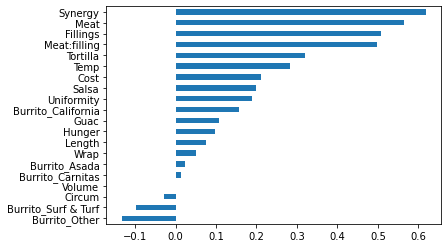

In [290]:
coefficients.sort_values().plot.barh();

In [291]:
# This group will get the output result of Validation Accuracy

# Prepare X features and y target
features = ['Burrito', 'Cost', 'Hunger', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Guac']
target = 'Great'
X_test = test[features]
y_test = test[target]

# One Hot Encode Burrito Category
X_test_encoded = encoder.transform(X_test)

# Impute NaN values
X_test_imputed = imputer.transform(X_test_encoded)

# Scale values
X_test_scaled = scaler.transform(X_test_imputed)

# Fit the model
print('Validation Accuracy', model.score(X_test_scaled, y_test))

Validation Accuracy 0.7058823529411765
